In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import easydarkfigs
%matplotlib inline

In [2]:
%set_darkfigdir figures_dark/
%set_lightfigdir figures/

In [3]:
plt.style.use('cook')

In [4]:
colors = sns.color_palette('colorblind')
markers = ['o', 'D', 's', 'p', '*', 'X', '^']

In [5]:
from results import models, results, pcmds, data, radii_am, radii_kpc, dmods, regions
import results as rr

CPU times: user 16.2 ms, sys: 4.27 ms, total: 20.5 ms
Wall time: 24.7 ms


In [6]:
# %%time
# from drivers import filters, iso_models, drivers, sky

In [7]:
def plot_tau_cumulative(tau, ax=None, iso_step=0.01, lower=7.0, upper=10.1, xtext=7.5, text_kwargs={}, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(8,5))
    m = ppy.sfhmodels.TauModel(np.array([0., tau]), iso_step=-1)
    m.iso_edges = np.arange(0., 10.2, iso_step)
    ages, sfhs = m.get_vals()
    idx = (ages >= lower)&(ages<=upper)
    x = ages[idx]
    y = np.cumsum(sfhs)[idx]
    y /= y.max()
    ax.plot(x, y, **kwargs)
    kws = {'verticalalignment': 'bottom',
          'horizontalalignment':'left',
          'fontsize': 14, 
          'rotation': 14.}
    kws.update(text_kwargs)
    ytext = y[np.argmin(np.abs(x-xtext))] * 1.05
    ax.text(xtext, ytext, r'$\tau$ = '+f'{tau:.0f} Gyr', **kws)
    return ax

In [8]:
def residuals(k, ax=None, force_resim=False, median=False, residuals=True, residual_kwargs={}, model_kwargs={}, data_kwargs={},
              bins=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
    g = k.split('_')[0]
    if force_resim:
        if k in pcmds:
            pcmds.pop(k)
    if k not in pcmds:
        print(f'Modeling best fit for {k}')
        m = (results[k].median_model if median else results[k].best_model)
        is_ssp = isinstance(m.sfh_model, ppy.sfhmodels.SSPModel)
        if isinstance(m.distance_model, ppy.distancemodels.FixedDistance):
            m.distance_model.dmod = dmods[g]
        pcmds[k], _ = drivers[g].simulate(m, (256 if is_ssp else 128), sky_noise=sky[g], dither=False,
                                          mag_system=('ab' if g=='M31' else 'vega'), dark_per_sec=0.0127)
    pcmd_all = np.append(pcmds[k], data[k], axis=1)
    bins = bins or [np.arange(min(pcmd_all[0])-0.1, max(pcmd_all[0])+0.1, 0.05), np.arange(min(pcmd_all[1])-0.1, max(pcmd_all[1])+0.1, 0.05)]
    if residuals:
        ppy.plotting.plot_pcmd_contours(data[k], color='k', alpha=1.0, ls='-', lw=2, label='Data', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **data_kwargs)
        ppy.plotting.plot_pcmd_contours(pcmds[k], color=colors[1], alpha=1.0, ls='-', lw=1, label='Model', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **model_kwargs)
        a, ll, bins, norm, = ppy.plotting.plot_pcmd_residual(pcmds[k], data[k], ax=ax, bins=bins, **residual_kwargs)
    else:
        ppy.plotting.plot_pcmd_contours(data[k], alpha=1.0, ls='-', lw=2, label='Data', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **data_kwargs)
        ppy.plotting.plot_pcmd_contours(pcmds[k], color=model_kwargs.pop('color', colors[1]), alpha=1.0, ls='-', lw=1, label='Model', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **model_kwargs)
        norm = None
    ppy.plotting.plot_isochrone(iso_models[g], axes=ax, alpha=0.)
    return ax, norm

In [9]:
%%time
for i in [13,9]:
    print(i)
    rr.load_model(i, all_quads=False)
# rr.load_model(9, all_quads=False)

13
M87
Skipping M87_a1_m13
Skipping M87_b1_m13
Skipping M87_c1_m13
M87v2
Error loading  M87v2_a1_m13
object arrays are not supported
Error loading  M87v2_b1_m13
object arrays are not supported
Error loading  M87v2_c1_m13
object arrays are not supported
M49
Skipping M49_a1_m13
Skipping M49_b1_m13
Skipping M49_c1_m13
NGC3377
NGC4993
Skipping NGC4993_a1_m13
Skipping NGC4993_b1_m13
Skipping NGC4993_c1_m13
M31 Bulge
Skipping M31_e_m13
Skipping M31_d_m13
Skipping M31_c_m13
Skipping M31_b_m13
Skipping M31_a_m13
9
M87
M87v2
M49
NGC3377
NGC4993
M31 Bulge
CPU times: user 35.7 s, sys: 813 ms, total: 36.5 s
Wall time: 38.7 s


# Compare

In [10]:
r1 = results['NGC3377_a1_m9']
r2 = results['NGC3377_a1_m13']
r3 = results['NGC3377_b1_m9']
r4 = results['NGC3377_b1_m13']
r5 = results['NGC3377_c1_m9']
r6 = results['NGC3377_c1_m13']

In [11]:
ndiff1 = len(r1.df) - len(r2.df[~r2.df.live])
ndiff2 = len(r3.df) - len(r4.df[~r4.df.live])
ndiff3 = len(r5.df) - len(r6.df[~r6.df.live])

In [12]:
r1.df[:-ndiff1].tail()

,niter,nc,eff,logl,logwt,logvol,logz,logzerr,h,delta_logz,...,logSFH2,logSFH3,logSFH4,dmod,live,logNpix,log_weights,dynesty_weights,likelihood_weights,weights
4364,4365.0,2381.0,0.90136,-178.92,-195.819985,-10.899,-194.12,0.18940,14.368,119.67,...,3.24200,4.4441,2.2253,30.588,False,4.473252,-114.444985,1.982324e-50,8.537678e-51,1.982324e-50
4365,4366.0,573.0,0.90051,-178.66,-195.679985,-10.901,-193.93,0.18927,14.347,119.46,...,3.62600,4.4835,3.2617,31.158,False,4.564753,-114.304985,2.280215e-50,1.107277e-50,2.280215e-50
4366,4367.0,360.0,0.90004,-178.61,-195.529985,-10.904,-193.75,0.18911,14.323,119.27,...,3.43240,4.3002,2.4883,30.569,False,4.379439,-114.154985,2.649232e-50,1.164048e-50,2.649232e-50
4367,4368.0,545.0,0.89924,-178.43,-195.409985,-10.906,-193.57,0.18893,14.295,119.08,...,1.12120,4.2069,3.5054,29.982,False,4.287605,-114.034985,2.987001e-50,1.393619e-50,2.987001e-50
4368,4369.0,80.0,0.89930,-178.36,-195.289985,-10.909,-193.41,0.18873,14.265,118.90,...,0.16371,1.7950,4.4915,30.147,False,4.492446,-113.914985,3.367834e-50,1.494668e-50,3.367834e-50


In [13]:
r2.df[:-400].tail()

,niter,nc,eff,logl,logwt,logvol,logz,logzerr,h,delta_logz,...,logSFH2,logSFH3,logSFH4,dmod,live,logNpix,log_weights,dynesty_weights,likelihood_weights,weights
4364,4365.0,30.0,0.92717,-179.19,-196.08,-10.899,-193.77,0.18583,13.831,119.89,...,0.67869,3.3111,4.5533,30.416,False,4.580070,-116.445366,2.681761e-51,1.960223e-51,2.681761e-51
4365,4366.0,430.0,0.92654,-178.88,-195.91,-10.901,-193.66,0.18574,13.817,119.78,...,3.08690,4.2965,3.2362,30.163,False,4.357094,-116.275366,3.178704e-51,2.672617e-51,3.178704e-51
4366,4367.0,37.0,0.92668,-178.80,-195.73,-10.904,-193.54,0.18570,13.811,119.67,...,2.65610,2.2584,4.3977,29.988,False,4.409662,-116.095366,3.805600e-51,2.895211e-51,3.805600e-51
4367,4368.0,323.0,0.92626,-178.04,-195.25,-10.906,-193.37,0.18607,13.866,119.55,...,0.47961,4.2865,3.1774,30.056,False,4.319242,-115.615366,6.150133e-51,6.190762e-51,6.150133e-51
4368,4369.0,761.0,0.92498,-177.95,-194.90,-10.909,-193.18,0.18656,13.939,119.38,...,2.33440,4.1759,3.2420,29.854,False,4.237013,-115.265366,8.727454e-51,6.773772e-51,8.727454e-51


In [14]:
new_mlls = {}
for k in tqdm(list(results.keys())):
    r = results[k]
    mll = float(r.max_logl)
    while (r.as_dynesty(max_logl=mll)['delta_logz'][-1] >= 1e-3):
        mll -= 10.
    new_mlls[k] = mll

100%|██████████| 23/23 [01:26<00:00,  3.74s/it]


In [15]:
old_mlls = {k: results[k].max_logl for k in new_mlls.keys()}

In [16]:
for k in tqdm(new_mlls.keys()):
    results[k].max_logl = new_mlls[k]

100%|██████████| 23/23 [00:02<00:00,  7.97it/s]


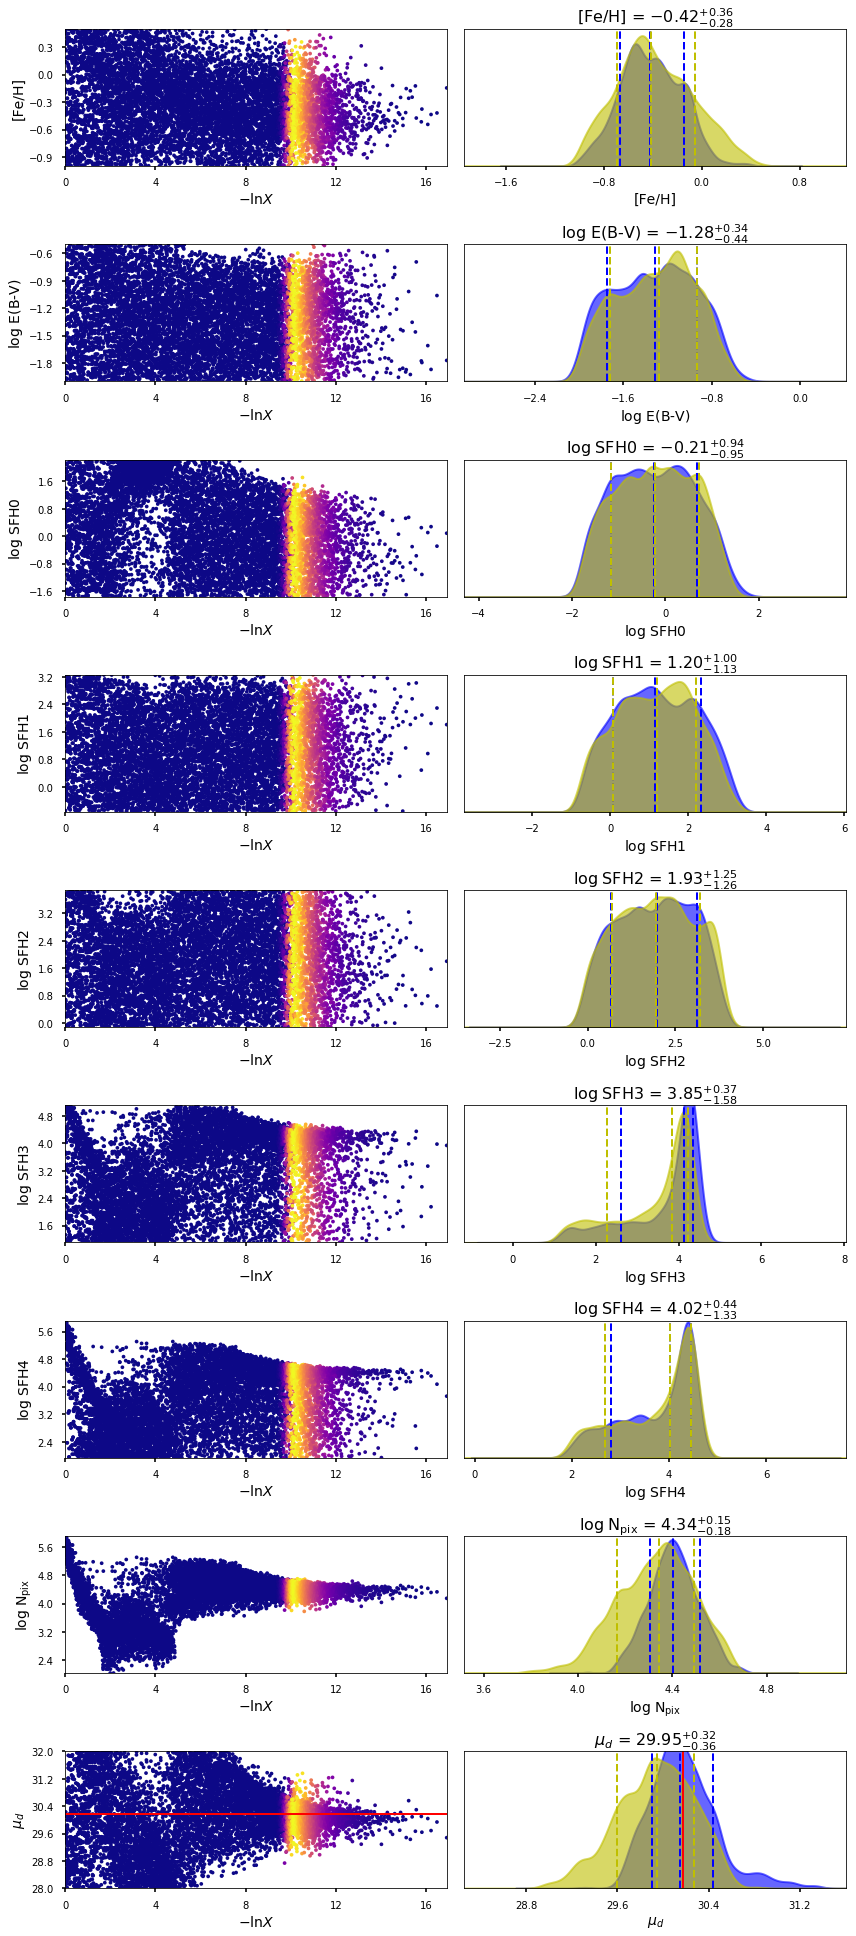

In [23]:
f, axes = r1.plot_trace();
r2.plot_trace(axes=axes, post_color='y');

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c31f710>,
      dtype=object)

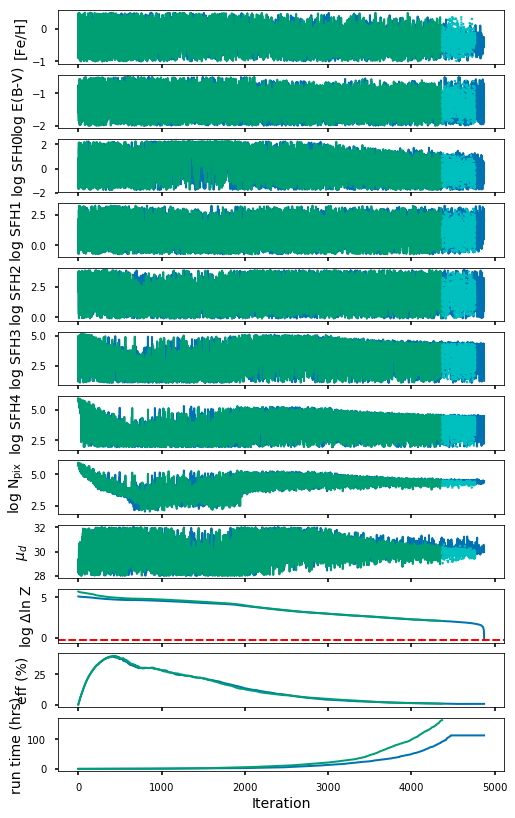

In [19]:
axes = r1.plot_chains();
r2.plot_chains(axes=axes)

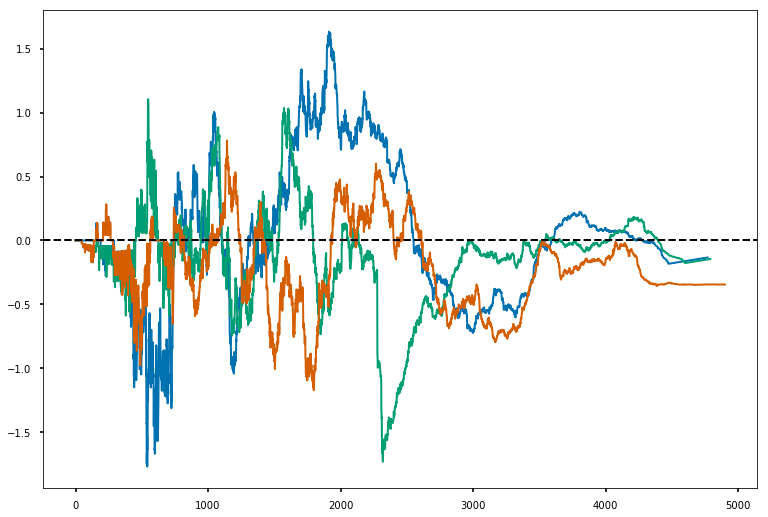

In [24]:
plt.plot(r1.df.eff - r2.df.eff)
plt.plot(r3.df.eff - r4.df.eff)
plt.plot(r5.df.eff - r6.df.eff)
plt.axhline(y=0, ls='--', color='k')

In [25]:
for r in [r1, r2, r3, r4, r5, r6]:
    r.df['ave_time'] = r.df.time_elapsed / np.cumsum(r.df.nc) * 3600.

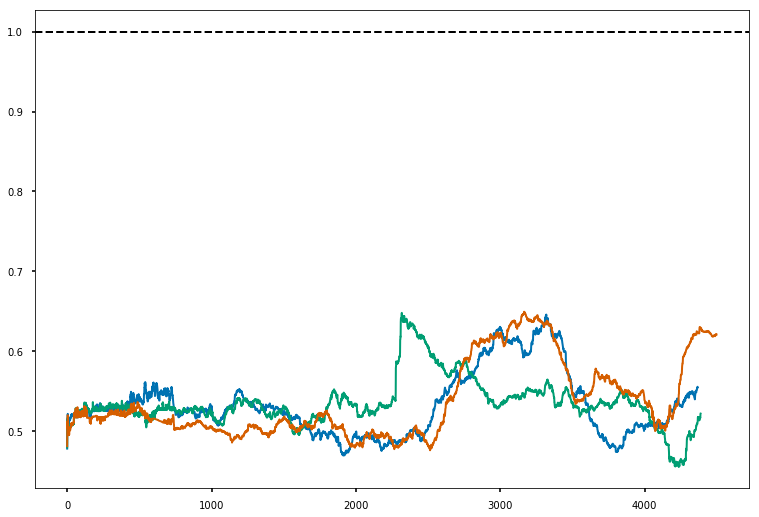

In [26]:
plt.plot(r1.df.time_elapsed / r2.df.time_elapsed)
plt.plot(r3.df.time_elapsed / r4.df.time_elapsed)
plt.plot(r5.df.time_elapsed / r6.df.time_elapsed)
plt.axhline(y=1, ls='--', color='k')

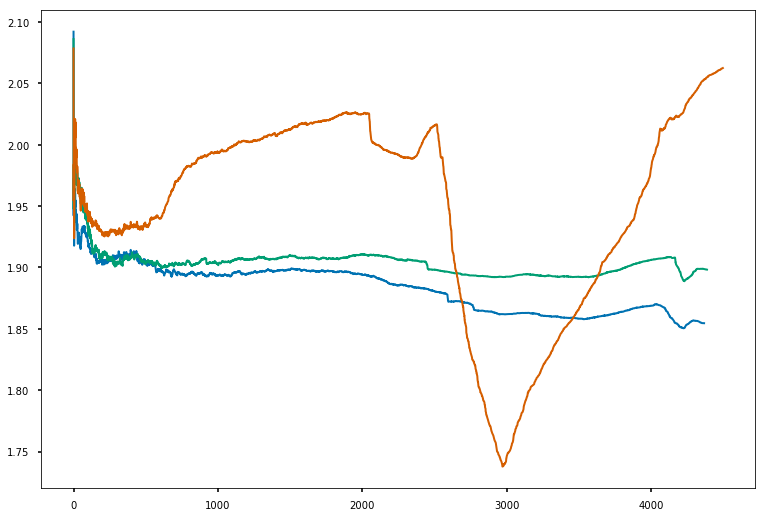

In [27]:
plt.plot(r2.df.ave_time / r1.df.ave_time)
plt.plot(r4.df.ave_time / r3.df.ave_time)
plt.plot(r6.df.ave_time / r5.df.ave_time)

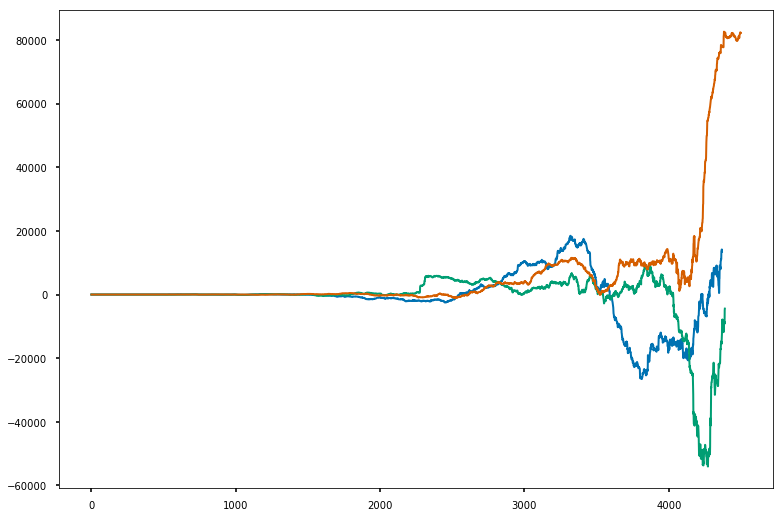

In [28]:
plt.plot(np.cumsum(r1.df.nc) - np.cumsum(r2.df[~r2.df.live].nc))
plt.plot(np.cumsum(r3.df.nc) - np.cumsum(r4.df[~r4.df.live].nc))
plt.plot(np.cumsum(r5.df.nc) - np.cumsum(r6.df[~r6.df.live].nc))


In [30]:
is_dark = False

Text(0.5, 1.0, 'NGC3377')

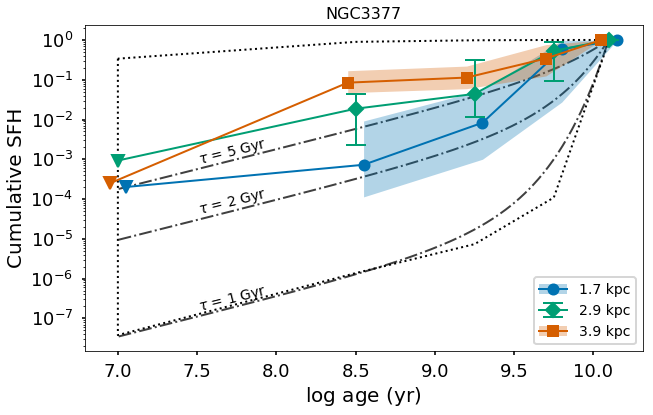

In [31]:
# %%savefig_dark_light SFH_NGC3377_upper.pdf
fig, ax = plt.subplots(figsize=(10,6))
g = 'NGC3377'
lines = {}
for i, r in enumerate(['a1', 'b1', 'c1']):
    k = f'{g}_{r}_m9'
    res = results[k]
    ax, lines[k], _, _, _ = res.plot_cum_sfh(ax=ax, color=colors[i], show_prior=((r=='c1') and (not is_dark)),
                                            xshift=-0.05*(i-1), show_bars=(i%2), show_fill=((i+1)%2),
                                            width=68., dark=is_dark, marker=markers[i], show_uppers=True)
for t in [1., 2., 5.]:
    plot_tau_cumulative(t, ax=ax, alpha=.75, color=('w' if is_dark else 'k'), zorder=-1, lw=2., ls='-.')
ax.legend([lines[k] for k in lines.keys()], [f'{radii_kpc[k]:.1f} kpc' for k in lines.keys()])
ax.set_title(g)

Text(0.5, 1.0, 'NGC3377')

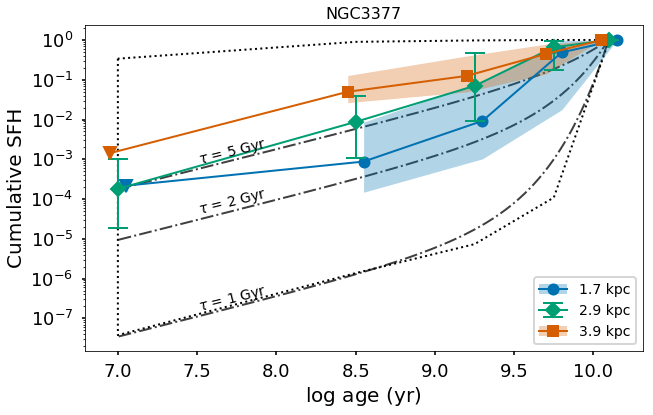

In [32]:
# %%savefig_dark_light SFH_NGC3377_upper.pdf
fig, ax = plt.subplots(figsize=(10,6))
g = 'NGC3377'
lines = {}
for i, r in enumerate(['a1', 'b1', 'c1']):
    k = f'{g}_{r}_m13'
    res = results[k]
    ax, lines[k], _, _, _ = res.plot_cum_sfh(ax=ax, color=colors[i], show_prior=((r=='c1') and (not is_dark)),
                                            xshift=-0.05*(i-1), show_bars=(i%2), show_fill=((i+1)%2),
                                            width=68., dark=is_dark, marker=markers[i], show_uppers=True)
for t in [1., 2., 5.]:
    plot_tau_cumulative(t, ax=ax, alpha=.75, color=('w' if is_dark else 'k'), zorder=-1, lw=2., ls='-.')
ax.legend([lines[k] for k in lines.keys()], [f'{radii_kpc[k]:.1f} kpc' for k in lines.keys()])
ax.set_title(g)

Text(0.5, 1.0, 'NGC3377, 3.9 kpc')

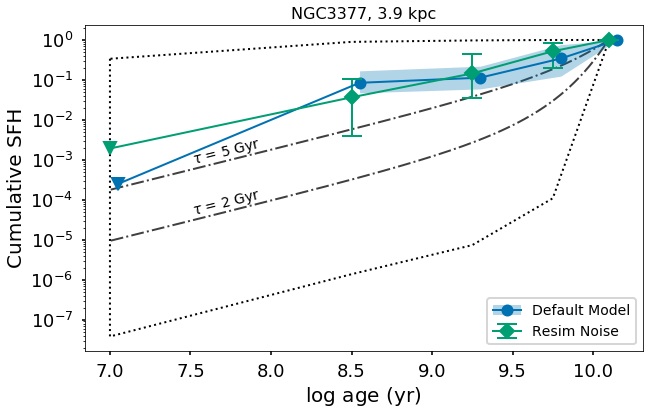

In [81]:
# %%savefig_dark_light SFH_compare_NGC3377_c_upper.pdf
models = {
    9: 'Default Model',
    10: 'Fixed Distance',
    11: 'Closed Box MDF',
    12: r'$\tau$ SFH',
    13: 'Resim Noise'
}
fig, ax = plt.subplots(figsize=(10,6))
g = 'NGC3377_c1'
lines = {}
for i, m in enumerate([9, 13]):
    k = f'{g}_m{m}'
    res = results[k]
    ax, lines[m], _, _, _ = res.plot_cum_sfh(ax=ax, color=colors[i], show_prior=((i==1) and (not is_dark)),
                                            xshift=-0.05*(i-1), show_bars=(i%2), show_fill=((i+1)%2),
                                            width=68., dark=is_dark, marker=markers[i], show_uppers=True)
for t in [2., 5.]:
    plot_tau_cumulative(t, ax=ax, alpha=.75, color=('w' if is_dark else 'k'), zorder=-1, lw=2., ls='-.')
ax.legend([lines[m] for m in lines.keys()], [models[m] for m in lines.keys()])
ax.set_title(r'NGC3377, 3.9 kpc')

In [93]:
im = np.random.random((2, 512,512)) * 1000

In [94]:
%%time
im = np.random.poisson(im, size=((10,)+im.shape)).astype(np.float32)

CPU times: user 450 ms, sys: 6.74 ms, total: 457 ms
Wall time: 461 ms


In [95]:
import pcmdpy as ppy
f = ppy.instrument.default_ngc3377_filters()

In [97]:
%%time
mags = np.array([f[i].counts_to_mag(im[:,i].flatten()) for i in range(len(f))])

CPU times: user 74.4 ms, sys: 15.4 ms, total: 89.8 ms
Wall time: 89.4 ms


In [98]:
%%time
pcmd = ppy.utils.make_pcmd(mags)

CPU times: user 12.1 ms, sys: 9.45 ms, total: 21.6 ms
Wall time: 18.6 ms
